In [1]:
from helper_fun import *

### class developed by me to do basline EDA for raw dataset
from EDA import EDA

In [2]:
df = pd.read_parquet('time_series_dset.pq')
df.head(2)

,item,date,f1,f2,f3
0,1000.84.30,1990-03-01 00:00:01,40.0,1.0,0.0
1,1000.84.23,1990-03-01 00:00:01,1470.0,1.0,0.0


In [3]:
eda_obj =EDA()
eda_obj.fit_transform(df)

Calculating Dataset Statistics
------------------------------------------------------------------------------------

univeriate categorical analysis completed for column: item
univeriate categorical analysis completed for column: date
univeriate numerical analysis completed for column: f1
univeriate numerical analysis completed for column: f2
univeriate numerical analysis completed for column: f3


In [4]:
eda_obj.summary()

Dataset statistics 
 Number of variables:            5 
 Number of observations:         25242100 
 Missing cells:                  0 
 Missing cells (%):              0.0 
 Empty variables count:          0 
 Empty variables/all nulls:      [] 
 ------------------------------------------------------------------------------------
 Variable types 
 Categorical variables:           2 
 Numerical variables:             3 
 Unknown variables:               0 
 ------------------------------------------------------------------------------------

 Univeriate EDA of Numerical Features



,missing_percentage,mean_value,standard_deviation,skew,skewness,kurtosis,kurtosis_R,chi_stat_normality
f1,0.0,901.788112,497600.575364,5024.021367,Left skewed,25241224.087079,"higher kurtosis, heavier tail","[139239128086.99966, 0.0]"
f2,0.0,2.485928,6687.697933,5024.146937,Left skewed,25242065.280902,"higher kurtosis, heavier tail","[1290720723.948574, 0.0]"
f3,0.0,3.381609,993.713736,3783.014805,Left skewed,15186736.499736,"higher kurtosis, heavier tail","[12799187777.278662, 0.0]"


Univeriate EDA of Categorical Features



,missing_percentage,distinct_values,unique_percentage
item,0.0,256.0,0.00
date,0.0,5524594.0,21.89


Bivariate EDA of Categorical Features
 Numerical Features ANOVA Scores

No Target columns Provided

 Categorical Features Chi Square Scores

No Target columns Provided

 Correltion with target

No Target columns Provided


In [5]:
### aggregate(groupby) all the rows with respect to minutes. 
df['date'] = pd.to_datetime(df['date']).dt.strftime("%Y-%m-%d-%H:%M")
df = df.groupby(['item','date']).sum()
df.reset_index(inplace=True)

In [2]:
# df.to_parquet("parsed_df.parquet.gzip")
df = pd.read_parquet("parsed_df.parquet.gzip")
df.head(3)

,item,date,f1,f2,f3
0,1000.84.0,1990-03-01-01:07,68.0,1.0,0.0
1,1000.84.0,1990-03-01-02:53,40.0,1.0,0.0
2,1000.84.0,1990-03-01-03:19,40.0,1.0,0.0


### There are 256 sku for which we need to generate forecast as per assignment we need to generate forecast for predict only 3 items (1000.84.25,1000.84.23,1000.84.26)

In [3]:
target_df = df[df['item'].isin(['1000.84.25','1000.84.23','1000.84.26'])]

In [4]:
target_df['date'] = pd.to_datetime(target_df['date'],format="%Y-%m-%d-%H:%M")

In [5]:
target_df['date'].dt.day.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 11, 12])

In [6]:
target_df['Year_Months_day'] = target_df['date'].dt.strftime("%Y-%m-%d")

In [7]:
target_df.head(2)

,item,date,f1,f2,f3,Year_Months_day
248420,1000.84.23,1990-03-01 00:00:00,435.600000,1.0,0.0,1990-03-01
248421,1000.84.23,1990-03-01 00:01:00,369.333333,1.0,0.0,1990-03-01


In [8]:
### cleaning the f1 feature first
data = target_df.pivot(index='date', columns='item', values='f1')

In [9]:
date_df = pd.DataFrame(date_range(target_df['date'].min(),target_df['date'].max()),columns=['date'])
date_df.head(2)

,date
0,1990-03-01 00:00:00
1,1990-03-01 00:01:00


In [10]:
date_df = date_df.merge(data.reset_index(),on=['date'],how= 'left')

<AxesSubplot:xlabel='date'>

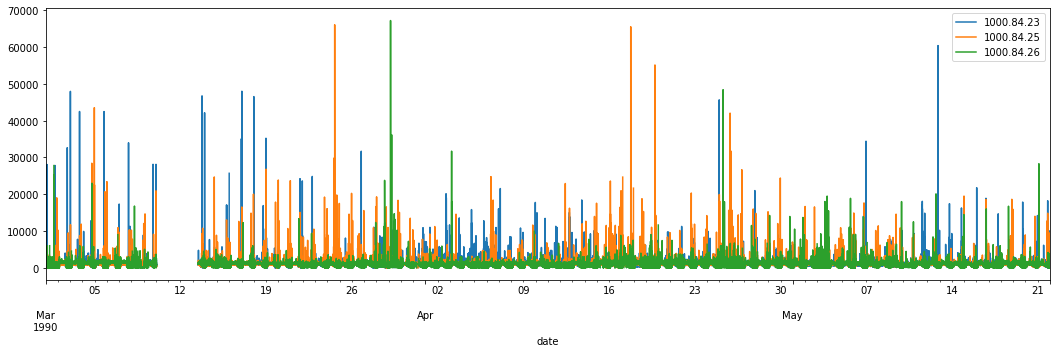

In [11]:
date_df.set_index('date',inplace=True)
date_df.plot(figsize=(18,5))

As per the plot, there are missing values between 1990-03-09 21:17:00,1990-03-13 10:54:00 since it is a large gap we can not use bfill and ffill for such a large gap, we can fill it by interpolation the function but values are changing very frequently here hence taking a chunk of data from previous days and filling the gap

### please review helper function script for fill_data function details

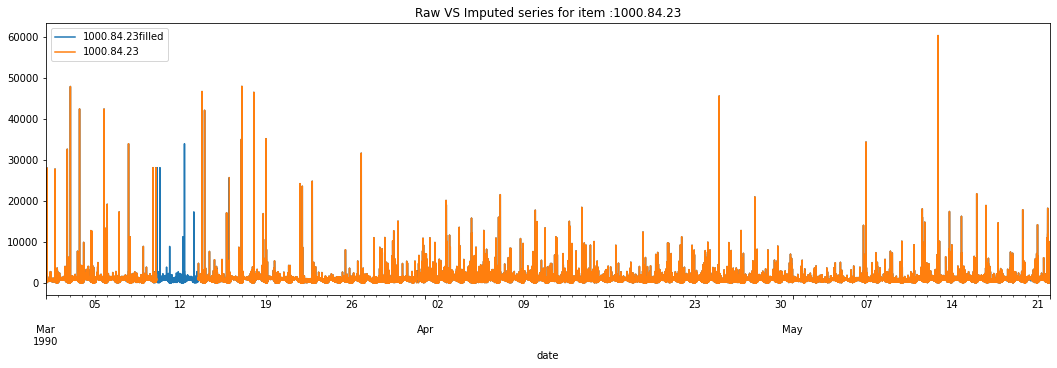

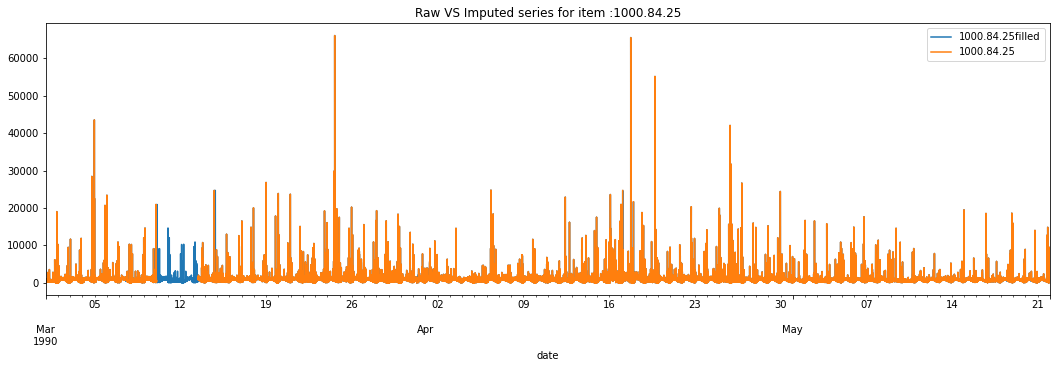

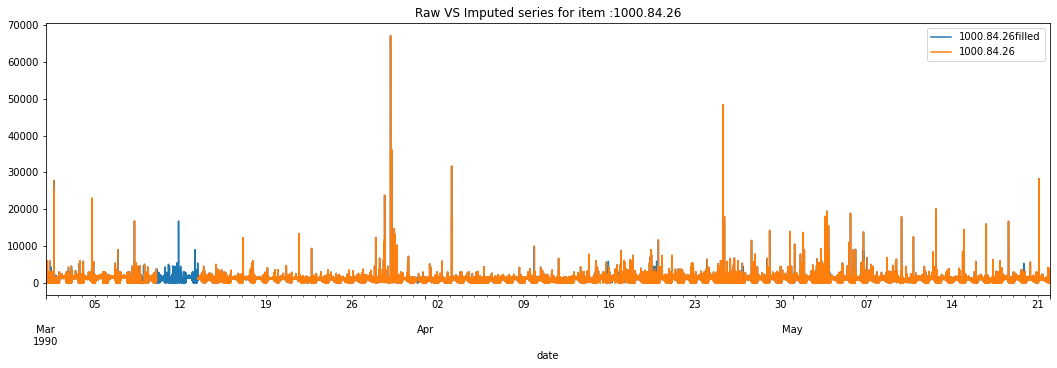

In [12]:
for item in ['1000.84.23','1000.84.25','1000.84.26']:
    date_df[item+'filled'] = fill_data(date_df[item].values)
    date_df[item+'filled'].bfill(inplace=True)## for any remaining missing value
    date_df[[item+'filled',item]].plot(figsize=(18,5),title= f"Raw VS Imputed series for item :{item}")
    plt.show()

In [13]:
### we have some outliers in the data lets clean them up with 3 SD limits

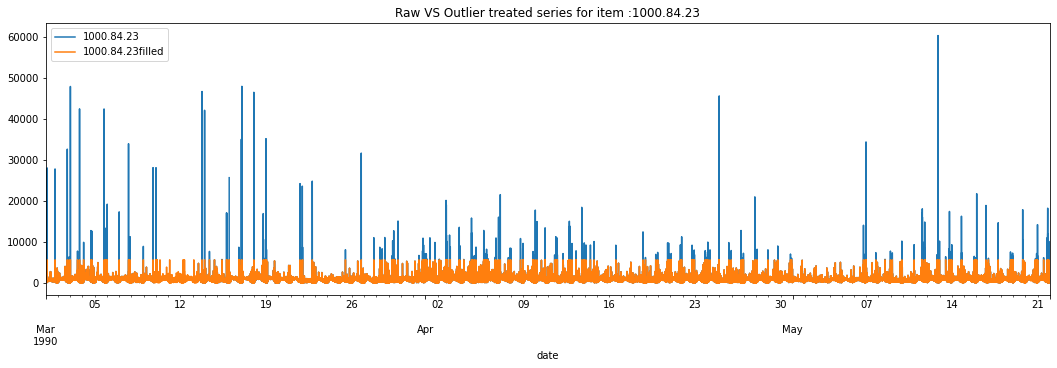

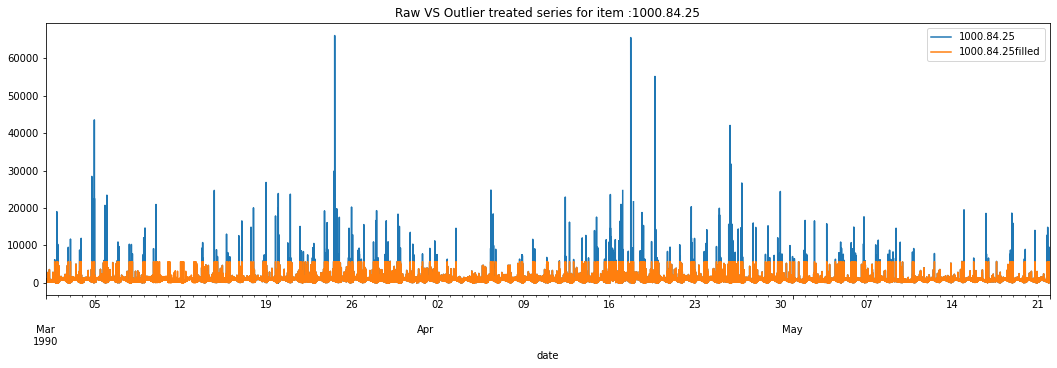

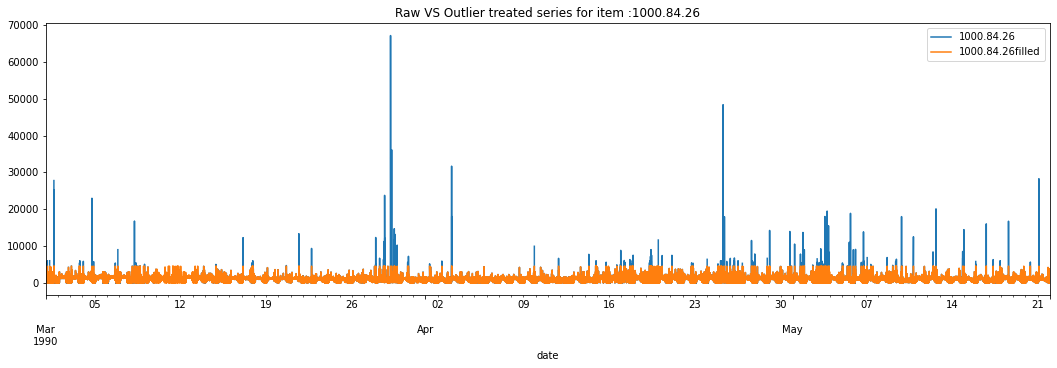

In [14]:
for item in ['1000.84.23','1000.84.25','1000.84.26']:
    date_df[item+'filled'] = stam_outlier(date_df[item+'filled'].values)
    date_df[[item,item+'filled']].plot(figsize=(18,5),title= f"Raw VS Outlier treated series for item :{item}")
    plt.show()

Now as the data is treated completely

<AxesSubplot:xlabel='date'>

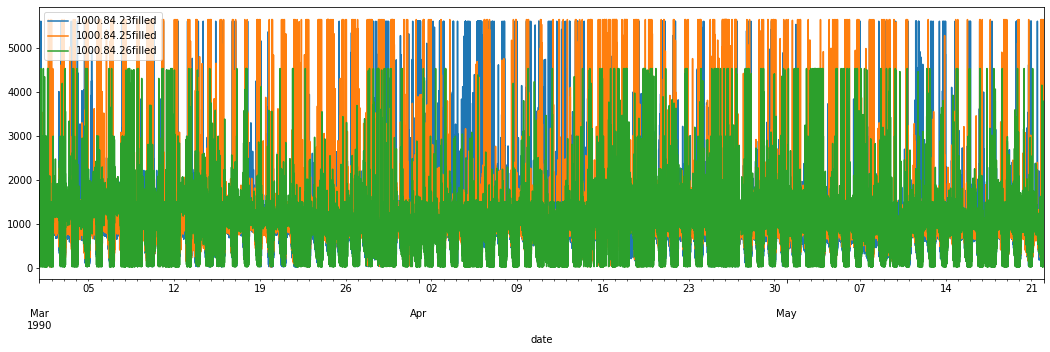

In [15]:
date_df = date_df[[i for i in date_df.columns if 'filled' in i]]
date_df.plot(figsize=(18,5))

<AxesSubplot:xlabel='date'>

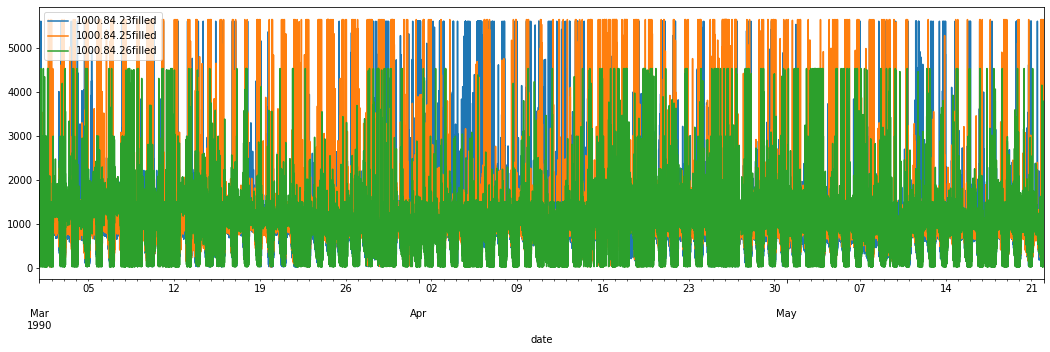

In [16]:
## scaling data usng min max scaler
sc_df= date_df
sc_df.plot(figsize=(18,5))

## As we are going to use parametric model checking for stationary

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
for cols in sc_df.columns:
    dftest = adfuller(sc_df[cols].values[:10000], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (cols ,dfoutput['p-value'])

1000.84.23filled 7.984100062159616e-13
1000.84.25filled 1.9936823711697716e-09
1000.84.26filled 1.6936383187746712e-08


### as p-values are less then 0.05, series are alreay stationary

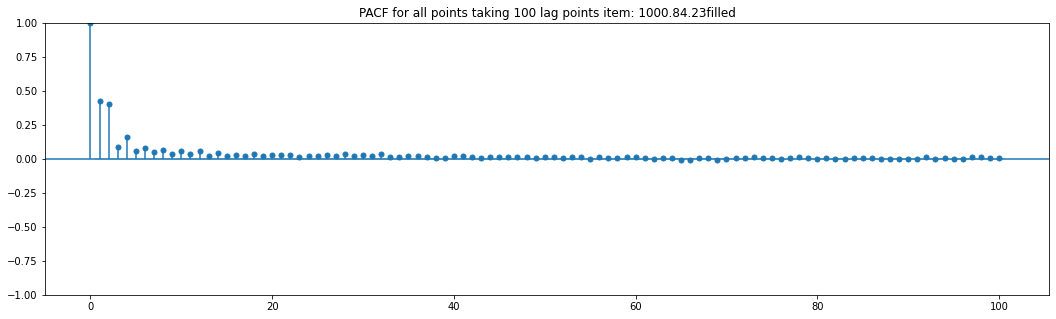

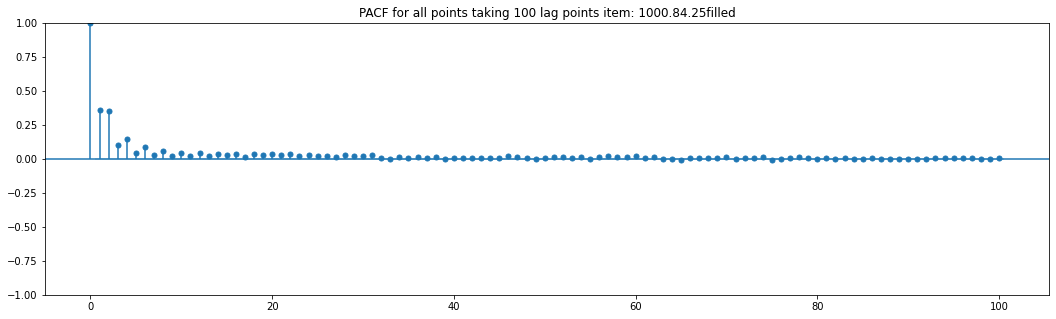

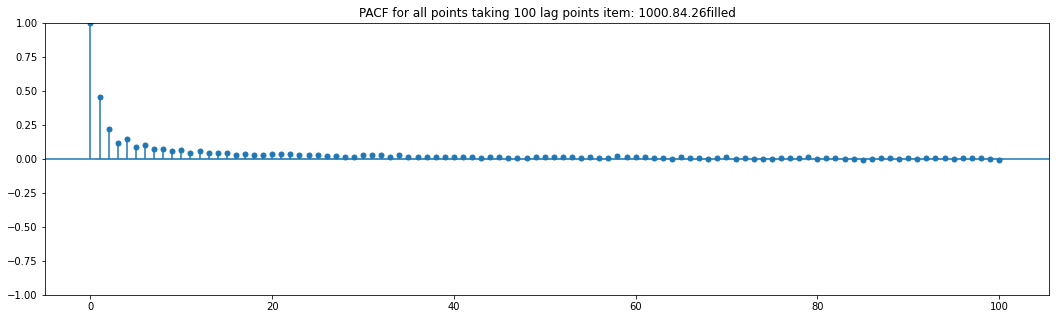

In [19]:
### checking the pacf for autocorrelation lags

from statsmodels.graphics.tsaplots import plot_pacf
for cols in sc_df.columns:
    fig, ax = plt.subplots(figsize=(18,5))
    plot_pacf(sc_df[cols],lags = 100,ax =ax,title=f'PACF for all points taking 100 lag points item: {cols}')
    plt.show()

In [20]:
sc_df.head(2)

,1000.84.23filled,1000.84.25filled,1000.84.26filled
date,,,
1990-03-01 00:00:00,435.600000,419.500000,1500.0
1990-03-01 00:01:00,369.333333,483.833333,1500.0


In [21]:
## Will be using forecaster to utilize multiple models
cols = '1000.84.23filled'
current_df = sc_df[[cols]]
f = Forecaster(y=current_df[cols].values,current_dates=current_df.index)

In [22]:
f.set_test_length(.3)       
f.generate_future_dates(30)

In [23]:
f

Forecaster(
    DateStartActuals=1990-03-01T00:00:00.000000000
    DateEndActuals=1990-05-21T23:59:00.000000000
    Freq=T
    N_actuals=118080
    ForecastLength=30
    Xvars=[]
    TestLength=35424
    ValidationLength=1
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

## LSTM Forecasting

2023-03-27 18:51:23.687609: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 18:52:14.046028: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Epoch 1/15
1033/1033 [==============================] - 65s 60ms/step - loss: 0.0784 - val_loss: 0.0565
Epoch 2/15
1033/1033 [==============================] - 43s 42ms/step - loss: 0.0706 - val_loss: 0.0562
Epoch 3/15
1033/1033 [==============================] - 38s 37ms/step - loss: 0.0703 - val_loss: 0.0554
Epoch 4/15
1033/1033 [==============================] - 38s 37ms/step - loss: 0.0700 - val_loss: 0.0555
Epoch 5/15
1033/1033 [==============================] - 41s 40ms/step - loss: 0.0697 - val_loss: 0.0554
Epoch 6/15
1033/1033 [==============================] - 38s 37ms/step - loss: 0.0694 - val_loss: 0.0557
Epoch 7/15
1033/1033 [==============================] - 41s 39ms/step - loss: 0.0692 - val_loss: 0.0554
Epoch 8/15
1033/1033 [==============================] - 38s 37ms/step - loss: 0.0690 - val_loss: 0.0552
Epoch 9/15
1033/1033 [==============================] - 41s 40ms/step - loss: 0.0689 - val_loss: 0.0553
Epoch 10/15
1033/1033 [==============================] - 38s 37m

<AxesSubplot:xlabel='Date', ylabel='Values'>

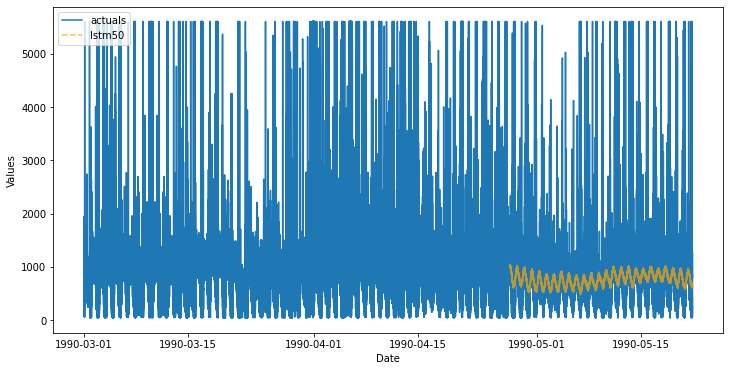

In [38]:
f.set_estimator('lstm')  
from tensorflow.keras.callbacks import EarlyStopping

f.manual_forecast(
    call_me='lstm50',
    lags=50,
    epochs=15,
    validation_split=.3,
    shuffle=True,
    callbacks=EarlyStopping(
        monitor='val_loss',               
        patience=5,
    ),
    lstm_layer_sizes=(16,16,16),
    dropout=(0,0,0),
)

f.plot_test_set(ci=True)

<AxesSubplot:xlabel='Date', ylabel='Values'>

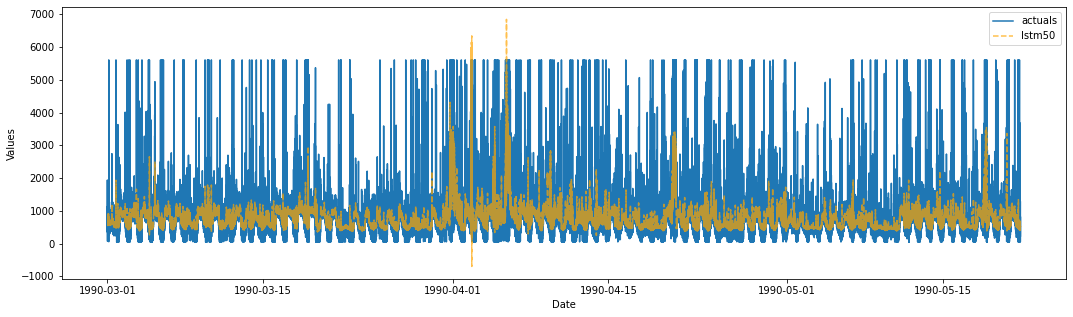

In [47]:
f.plot_fitted(figsize=(18,5))

In [40]:
f.tf_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 50, 16)            1152      
_________________________________________________________________
lstm_4 (LSTM)                (None, 50, 16)            2112      
_________________________________________________________________
lstm_5 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 30)                510       
Total params: 5,886
Trainable params: 5,886
Non-trainable params: 0
_________________________________________________________________


In [39]:
### LSTM model 
f.tf_model.save("LSTM_f1_model.h5")

## Next 30 days forecast for f1 and item 1000.84.23filled

In [45]:
f.forecast

[488.5474529277257,
 507.6125951682177,
 506.5678860925656,
 493.932127956187,
 490.3412800836679,
 496.47967689671077,
 530.028985284006,
 503.45142713613325,
 510.22231485408275,
 514.1416432490189,
 508.878240575046,
 497.7674698539142,
 515.6894832864692,
 504.7477639049046,
 513.4810324206023,
 505.66502087886636,
 513.5855489504622,
 510.7709851610343,
 504.07620372574075,
 498.84399011147207,
 505.84921052533787,
 514.1870996445454,
 524.9189564701212,
 517.0238524591618,
 530.5216231180048,
 512.9165602097314,
 513.321852086633,
 514.5325018908445,
 505.439895591533,
 521.1120662944115]

In [41]:
f.mape

0.6030025050339015

In [ ]:
### USING ARIMA model for 

In [ ]:
### Series is highly fluctuating we can 

In [25]:
f.set_estimator('arima') 
f.set_test_length(.3)       
f.generate_future_dates(30)

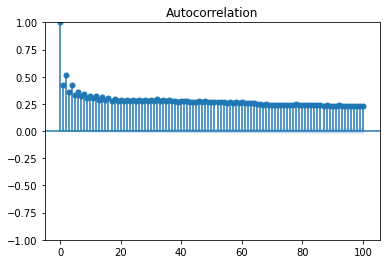

In [28]:
f.plot_acf(lags = 100)
plt.show()

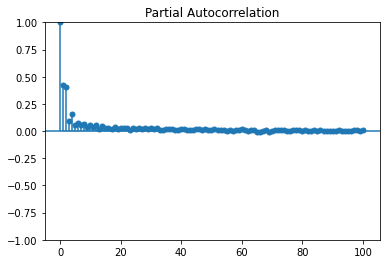

In [29]:
f.plot_pacf(lags = 100)
plt.show()

In [31]:
### making an ar 6 model based on pacf plot 
f.manual_forecast(call_me="arima_baseline",order=(7, 0, 0),enforce_stationarity=True)

<AxesSubplot:xlabel='Date', ylabel='Values'>

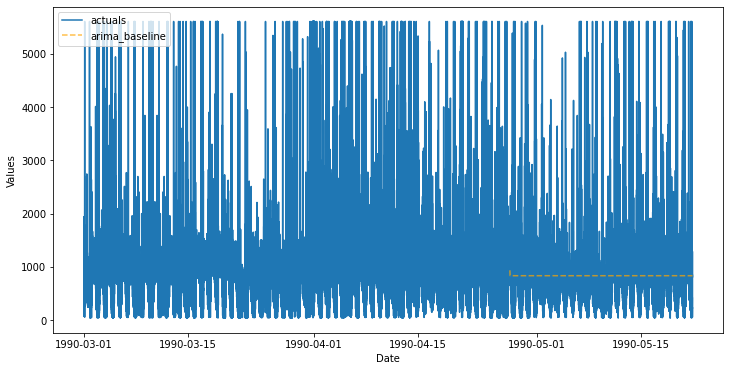

In [32]:
f.plot_test_set(ci=True)

In [33]:
f.mape

0.7930369792422607

## ARIMA is throwing mean value as forecast